Introduction
------------

In this demo, we will focus on CF ensemble learning methods by directly predicting the reliability of each probability score from the base classifiers (users) in both `R` and `T` without needing to first guesstimating the labels of the test set (T). 

Specicially, given `T` (rating matrix of the test set) for which we wish to predict its corresponding class labels, we will break down this predictive task into the following subproblems: 

1. Predict reliability of `T`; that is, predict T's probability filter (reliability matrix) where 0s represent unreilable entries (e.g., FPs and FNs) and 1s represent reliable entries (e.g., TPs and TNs)
  - The reliability of `R` is known since we know the (true) labels for the training set. 

2. Run a chosen collaborative filtering algorithm to reestimate the rating matrix combining the ratings from the training set (`R`) and those from the test set (`T`)
  - Recall from **Demo Part 1 and 2** that the purpose of probaiblity filter is to help us select the entries of R and T that will enter the optimization objective (see Part 2) while the remaining entries get left out; that is, we wish to find the latent factors for users (classifiers) and items (data) such that they approximate either the rating (probability score) or the label well. 
  - Reliable entries should enter the optimization objectve while unreliable entries are typically left out (unless your loss function somehow can take into account of these entries, see C-square loss for an example)

3. Once we get `Th` (the re-estimated `T`), we will then combine their ratings to formulate our final class label predictions as usual (e.g., mean, majority vote, stacking)

In [1]:
#@title Import Basic Libraries
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import os, sys

# Colab 
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# Plotting
import matplotlib.pylab as plt
# %matplotlib inline

from matplotlib.pyplot import figure
import seaborn as sns
from IPython.display import display

# Progress
from tqdm import tqdm

################################################################
# Configure system environment
# - Please modify input_dir according to your local enviornment
#
################################################################

cur_dir = os.getcwd()
project_dir = 'machine_learning_examples/cf_ensemble'
if IN_COLAB: 
    # Run this demo on Google Colab
    from google.colab import drive
    drive.mount('/content/drive')
    
    # Parameters for data
    input_dir = f"/content/drive/MyDrive/Colab Notebooks/{project_dir}"
    # /content/drive/MyDrive/Colab Notebooks/machine_learning_examples/data/data-is-life

    sys.path.append(input_dir)
else: 
    input_dir = cur_dir
    
if input_dir != cur_dir: 
    sys.path.append(input_dir)
    print(f"> Adding {input_dir} to sys path ...")
    print(sys.path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
> Adding /content/drive/MyDrive/Colab Notebooks/machine_learning_examples/cf_ensemble to sys path ...
['', '/content', '/env/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.7/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/MyDrive/Colab Notebooks/machine_learning_examples/cf_ensemble', '/content/drive/MyDrive/Colab Notebooks/machine_learning_examples/cf_ensemble']


In [2]:
#@title Import Tensorflow and CF-Related Libraries
import tensorflow as tf
print(tf.__version__)
# import tensorflow_probability as tfp
# tfd = tfp.distributions
from tensorflow import keras

# from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda, Embedding
from tensorflow.keras.optimizers import RMSprop
from keras.utils.vis_utils import plot_model
from tensorflow.keras import backend as K
#################################################################

# Scikit-learn 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_predict, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
#################################################################

# CF-ensemble-specific libraries
import utils_stacking as ustk
import utils_classifier as uclf
import utils_sys as usys
import utils_cf as uc 
import polarity_models as pmodel
from polarity_models import Polarity
import scipy.sparse as sparse
from utils_sys import highlight
#################################################################

# Misc
import pprint
import tempfile
from typing import Dict, Text

np.set_printoptions(precision=3, edgeitems=5, suppress=True)

2.8.0


> n_classes: 2
[0 1]

> counts:
Counter({0: 4465, 1: 535})



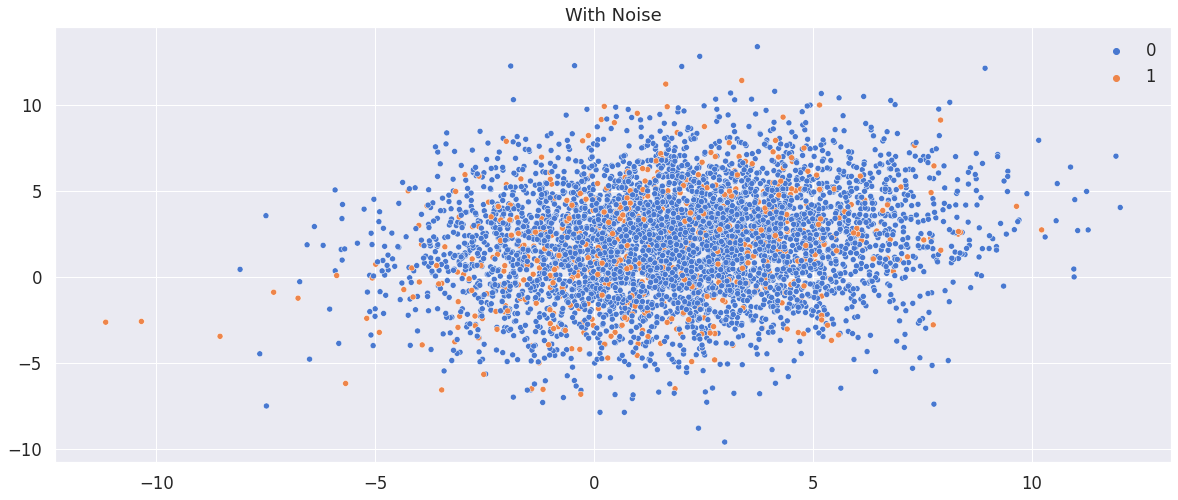

In [3]:
#@title Generate Training Data
%matplotlib inline
import data_pipeline as dp

max_class_ratio=0.99

# get the dataset
X0, y0 = dp.generate_imbalanced_data(class_ratio=max_class_ratio, verbose=1)

In [4]:
#@title Define and Choose Base Classifiers
base_learners = [
                 ('RF', RandomForestClassifier(n_estimators= 200, 
                                                   oob_score = True, 
                                                   class_weight = "balanced", 
                                                   random_state = 20, 
                                                   ccp_alpha = 0.1)), 
                 ('KNNC', KNeighborsClassifier(n_neighbors = len(np.unique(y0))
                                                     , weights = 'distance')),
                #  ('SVC', SVC(kernel = 'linear', probability=True,
                #                    class_weight = 'balanced'
                #                   , break_ties = True)), 

                 ('GNB', GaussianNB()), 
                 ('QDA',  QuadraticDiscriminantAnalysis()), 
                 ('MLPClassifier', MLPClassifier(alpha=1, max_iter=1000)), 
                 # ('DT', DecisionTreeClassifier(max_depth=5)),
                 # ('GPC', GaussianProcessClassifier(1.0 * RBF(1.0))),
                ]

In [5]:
#@title Generate Rating Matrices
import cf_models as cm

tLoadPretrained = False
######################
fold_number = 0
n_iterations = 1
data_dir = os.path.join(input_dir, 'data')
######################

if not tLoadPretrained:  
    # Use the previously selected base predictors (`base_learners`) to generate the level-1 dataset
    R, T, U, L_train, L_test = cm.demo_cf_stacking(input_data=(X0, y0), 
                                                   input_dir=input_dir, n_iter=n_iterations, 
                                                   base_learners=base_learners, # <<< base classifiers selected
                                                   verbose=1)
else: 
    R, T, U, L_train, L_test = dp.load_pretrained_level1_data(fold_number=fold_number, verbose=1, data_dir=data_dir)

# Derived quantities
n_train = R.shape[1]
p_threshold = uc.estimateProbThresholds(R, L=L_train, pos_label=1, policy='fmax')
lh = uc.estimateLabels(T, p_th=p_threshold) # We cannot use L_test (cheating), but we have to guesstimate
L = np.hstack((L_train, lh)) 
X = np.hstack((R, T))

assert len(U) == X.shape[0]
print(f"> shape(R):{R.shape} || shape(T): {T.shape} => shape(X): {X.shape}")

2.8.0


  0%|          | 0/1 [00:00<?, ?it/s]

(BaseCF) base est | name: RF, estimator: RandomForestClassifier(ccp_alpha=0.1, class_weight='balanced', n_estimators=200,
                       oob_score=True, random_state=20)
(BaseCF) base est | name: KNNC, estimator: KNeighborsClassifier(n_neighbors=2, weights='distance')
(BaseCF) base est | name: GNB, estimator: GaussianNB()
(BaseCF) base est | name: QDA, estimator: QuadraticDiscriminantAnalysis()
(BaseCF) base est | name: MLPClassifier, estimator: MLPClassifier(alpha=1, max_iter=1000)
(BaseCF) Base predictors:
[1]  RF: RandomForestClassifier(ccp_alpha=0.1, class_weight='balanced', n_estimators=200,
                       oob_score=True, random_state=20)
[2]  QDA: QuadraticDiscriminantAnalysis()
[3]  MLPClassifier: MLPClassifier(alpha=1, max_iter=1000)
[4]  KNNC: KNeighborsClassifier(n_neighbors=2, weights='distance')
[5]  GNB: GaussianNB()




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   27.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[info] Saving X_meta (shape=(3750, 5)) at:
/content/drive/MyDrive/Colab Notebooks/machine_learning_examples/cf_ensemble/data/train-0.npz



[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   36.1s finished


[info] Saving X_meta (shape=(1250, 5)) at:
/content/drive/MyDrive/Colab Notebooks/machine_learning_examples/cf_ensemble/data/test-0.npz

[info] Saving X_meta (shape=(1250, 5)) at:
/content/drive/MyDrive/Colab Notebooks/machine_learning_examples/cf_ensemble/data/test-0.npz

[result] 0.09929078014184396
(cf_write) Adding new attribute y:
[0 0 0 0 0 ... 0 1 0 0 0]
...
(cf_write) Saving X_meta at:
/content/drive/MyDrive/Colab Notebooks/machine_learning_examples/cf_ensemble/data/test-0.npz



100%|██████████| 1/1 [01:25<00:00, 85.30s/it]

[info] list of base classifiers:
['RF' 'KNNC' 'GNB' 'QDA' 'MLPClassifier']

R: Rating/probability matrix for the TRAIN set
> shape(R):(5, 3750) || shape(T): (5, 1250) => shape(X): (5, 5000)


In [6]:
#@title Reliability Model Parameters
# import utils_cf as uc
# import polarity_models as pmodel

include_label = True # include class labels as part of the training data?
policy_threshold = 'fmax'

### Using Seq2seq architecture(s) as the polarity model
- Assuming that the ordering of the users (base classifiers) is pre-specified and remains fixed
- By convention, let's denote **X** as the design matrix holding the training data while _**Y**_ represents the label
  - Note that the capitalized italic boldface is used to denote the label (normally in lower case _**y**_) because the label now is a collection of **sequences** representing reliablity of the ratings 
  - Since the training data is in the form of rating sequences, their corresponding labels are also in the form of sequences; reliability sequences to be specific. 
- Consider the ratings as a sequence of scores, arranged according to the ordering of the users. 
- The goal is then to predict the reliabilty score (polarity) for `T`
  - Reliability score associaed with a rating (T[i][j]) assumes a value, in its discrete form, of either 0 or 1 under 0-1 encoding. 
  - As a **relexation** (and also as a generalization), we will permit the reliabliity score to be any continous values between 0 and 1 (under 0-1 encoding)
  - Recall also that `polarity_models.polarity_matrix()` produces a score of either -1 (negative) and 1 (positive), which is equally legimate represenation for reliablity. 
    - Note that the polarity format (i.e., {-1, 1}-encoding) has the benefit of being easily generalized to incorporate the notion of **colors** (e.g. different types of positive and negative ratings) and **neutral** ratings (for entries that are neither positive nor negative). 
- Assuming that we adopt the 0-1 encoding scheme, then the target label _**Y**_ will consist of sequences of 0s and 1s (totaling `T.shape[1]` sequences), where 0s represent unreliable entries (of T) and 1s represent reliable entries of T. 
- Just like a regular classificaiton problem, the optimization objective is to find a function f() that maps X to _**Y**_ while minimzing a given loss

- We will use a seq2seq neural architecture to learn such a function
  - We will use the binary cross entropy (or BCE) loss for this task because the target label comprises values of either 0 or 1. 
  - Due to this setup (including the chosen loss fucntion), the resulting reliability predictions will not be perfectly 0s and 1s but likely some values that fall within the interval of [0, 1]. 

- Packing all the sequence predictions into a matrix, we the obtain a "prediction matrix" (_**Yh**_) that has the same interpretation as the probabilty filter, which is used to select the entries that ultimately go into the optimization objective for deriving latent factors for users (classifiers) and items (data)
  - If this seq2seq-based polarity model runs sucessfully, then we should expect _**Yh**_ to be close to the true label _**Y**_ in terms of the selected loss criteria such as the BCE loss. 




In [7]:
include_label = True # include class labels as part of the training data?

# P = uc.to_preference(Pc) # color matrix to probability filter (where {TP, TN} maps to 1 and {FP, FN} maps to 0)

# Make training set for the filter model (seq2seq in this case)
p_threshold = uc.estimateProbThresholds(R, L=L_train, policy=policy_threshold)
P, _ = uc.probability_filter(R, L_train, p_threshold)
X_train, Y_train = pmodel.make_seq2seq_training_data(R, Po=P, L=L_train, p_threshold=p_threshold,
                                                        include_label=include_label, verbose=1)

print(f"> shape(R): {R.shape}")
print(f"> shape(X_train): {X_train.shape}, shape(Y_train): {Y_train.shape}")

# P_test = uc.to_preference(Pc_test)

# Make test set for the filter model (seq2seq)
P_test, _ = uc.probability_filter(T, L_test, p_threshold)
X_test, Y_test = pmodel.make_seq2seq_training_data(T, Po=P_test, L=L_test, p_threshold=p_threshold, 
                                                      include_label=include_label, verbose=1)

print(f"> shape(T): {T.shape}")
print(f"> shape(X_test): {X_test.shape}, shape(Y_test): {Y_test.shape}")



[info] shape(X): (3750, 6, 1), shape(Y): (3750, 6, 1)
> shape(R): (5, 3750)
> shape(X_train): (3750, 6, 1), shape(Y_train): (3750, 6, 1)
[info] shape(X): (1250, 6, 1), shape(Y): (1250, 6, 1)
> shape(T): (5, 1250)
> shape(X_test): (1250, 6, 1), shape(Y_test): (1250, 6, 1)


In [8]:
# [test] Get some training examples
i = np.random.choice(range(R.shape[1]), 1)[0]
print(f"> Training instance X_train[{i}]=\n{X_train[i]}\n")
print(f"> Label instance Y_train[{i}]=\n{Y_train[i]}\n")


> Training instance X_train[2609]=
[[0.501]
 [0.   ]
 [0.075]
 [0.   ]
 [0.002]
 [0.   ]]

> Label instance Y_train[2609]=
[[0]
 [0]
 [0]
 [1]
 [0]
 [0]]



Model: "model_LSTM_all_state_h_return_state"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6, 1)]       0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 6, 10),      480         ['input_1[0][0]']                
                                 (None, 10),                                                      
                                 (None, 10)]                                                      
                                                                                                  
 lstm_1 (LSTM)                  (None, 6, 10)        840         ['lstm[0][0]',                   
                                                                

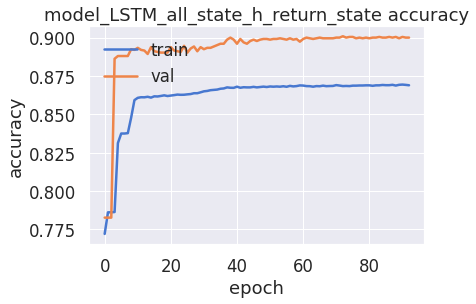

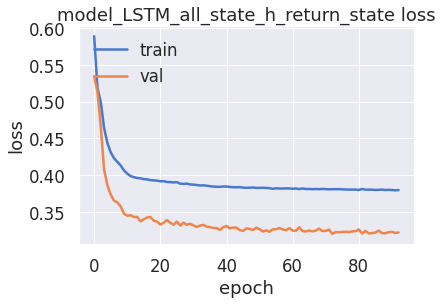

40/40 [==============================] - 1s 2ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00


[0.0, 0.0]

In [9]:
import seq2seq as smodel

epochs = 300
n_users = R.shape[0]

loss_fn = bce = tf.keras.losses.BinaryCrossentropy()
model_seq = smodel.get_stacked_lstm(n_users if not include_label else n_users+1, # n_users + 1 to include the class labels in the last row
                                    n_features=1, 
                                    n_units=n_users*2, 
                                    loss=loss_fn, activation='sigmoid', verbose=1)

history = smodel.train_test(model_seq, X_train, Y_train, X_test, Y_test, epochs=epochs, verbose=1)

model_seq.evaluate(X_test)

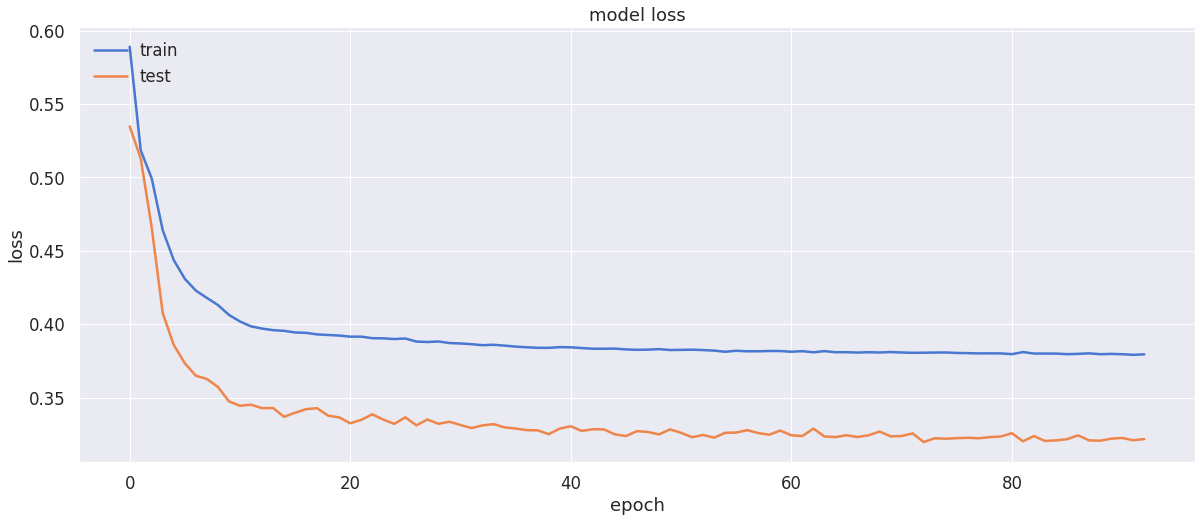

In [10]:
%matplotlib inline
f, ax1 = plt.subplots(nrows=1, ncols=1,figsize=(20,8))

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
#plt.show()

In [11]:
# Note that `X_test` contains the true label (L_test), which was only used to evaluate the reliability model itself

# Now for our main task of predicting T's class labels, surely we need to drop the class label portion of `X_test`. 
# We'll use zero-padding as was the format for the training data `X_train`
X_test[n_users] = 0.0 # <<< All test instances share the same zero padding format just like `X_train`

Y_test_est = model_seq.predict(X_test) 
Y_train_est = model_seq.predict(X_train) # Although we already know the probability filter for the training set, ... 
# ... we will need the "continuous representation" (instead of a 0-1 encoded matrix) to infer reliability thresholds
print(f"> shape(Y_pred): {Y_test_est.shape}") # (1250, 5, 1): n_samples x n_users x n_features
 
print()
i = np.random.choice(range(T.shape[1]), 1)[0]
print(f"> Show example prediciton at i={i}")
print(f"> T[:, {i}]:\n{T[:, i].reshape(-1, 1)}\n> L_test[{i}]: {L_test[i]}")
print(f"> Y_pred[{i}]:\n{Y_test_est[i]}\n")

> shape(Y_pred): (1250, 6, 1)

> Show example prediciton at i=613
> T[:, 613]:
[[0.499]
 [0.   ]
 [0.013]
 [0.   ]
 [0.012]]
> L_test[613]: 0
> Y_pred[613]:
[[0.098]
 [0.084]
 [0.168]
 [0.823]
 [0.216]
 [0.107]]



In [12]:
# [test] Get some predicted examples
test_ids = np.random.choice(range(T.shape[1]), 3)
Y_test_est[test_ids, :, :]

array([[[0.104],
        [0.099],
        [0.097],
        [0.82 ],
        [0.14 ],
        [0.107]],

       [[0.1  ],
        [0.088],
        [0.132],
        [0.84 ],
        [0.202],
        [0.107]],

       [[0.1  ],
        [0.089],
        [0.126],
        [0.843],
        [0.201],
        [0.106]]], dtype=float32)

In [13]:
# CF parameters
n_factors = 100
alpha = 100.0
conf_measure = 'brier' # Options: 'brier', 'uniform'

# `policy_threshold` should have been defined previously

n_users = R.shape[0]
n_test, n_seq_len, n_features = Y_test_est.shape

In [14]:
# Convert reliability scores in the test set into the matrix format, which is essentially 
# a "probability filter" where 0s represent unreliable entries and 1s represent unreliable entries 
# However, instead of the hard filter used previously in the training set, 
# this time, we will have a "soft" probability filter, meaning that the reliable entries are no longer 
# strictly 0 or 1 due to the property of the optimization (seq2seq model with BCE loss 
# will not lead to perfect 0-1 scores)
P_test = Y_test_est.squeeze().T

# Since we know the class label for the training set, the (hard) probability filter is a known quantity
# However, getting the soft filter for the training set is helpful for us to estimate the hard filter for the test set (T) later on
P_train = Y_train_est.squeeze().T 
print(f"> shape(P_test): {P_test.shape}, shape(P_train): {P_train.shape}")

> shape(P_test): (6, 1250), shape(P_train): (6, 3750)


In [15]:
lh_max_vote = uc.estimateLabels(T, p_th=p_threshold, pos_label=1)

# Estimated labels for T from the reliability model
acc_seq2seq = np.nan # accuracy for the label prediction in T using the reliability model

lh = lh_max_vote # use majority vote's label estimate as a default in case `include_label` was set to False
if include_label: 
    # if so, then the last row of P_train and P_test are the class labels (for the test split, the class labels are really the "predicted" labels)
    print("> `include_label` set to True => last row holds the (true) class labels for R and estimated labels for T ...")
    lh = P_test[n_users] # the last row is the predicted label

    # But the predictions are continous scores, we need to convert them into class labels in either 0 or 1
    p_th = P_train[n_users][L_train == 1].min()
    lh = lh_seq2seq = np.where(lh >= p_th, 1, 0)
    print(f"> probability threshold for the positive/minority class in training set (R): {p_th}")

    # NOTE:
    # Coming from a completely different model and inductive bias, this probability threshold 
    # will generally not be the same as those in `p_threshold` derived from the base predictors

    acc_seq2seq = np.sum(lh_seq2seq == L_test) / (len(L_test)+0.0)

    # Drop the class labels so that `P_train` and `P_test` will hold only the reliability scores (of the ratings in R and T respectively)
    P_train = P_train[:n_users, :]
    P_test = P_test[:n_users, :]

assert P_test.shape == T.shape
assert P_train.shape == R.shape

> `include_label` set to True => last row holds the (true) class labels for R and estimated labels for T ...
> probability threshold for the positive/minority class in training set (R): 0.09495753049850464


We also need to estimate the "hard" filter for T by first using the training data to estimate the reliability threshold

In [16]:
# Convert soft filter to a "hard" filter 
# Method 1: Use soft filter from training set to infer reliability threshold, from which to infer the test set filter
Pf_seq2seq, r_th = pmodel.infer_probability_filter(X=(R, T), 
                                                   L=L_train, 
                                                   P=(P_train, P_test),
                                                   p_th=p_threshold, verbose=1) # `r_th`: reliability threshold 
Pf_seq2seq = pmodel.to_polarity(Pf_seq2seq) # Most of the relevant function calls use polarity format (i.e. {-1, 1} encoding)

# NOTE: Logically, whether it's {0, 1} or {-1, 1} encoding is not too important here; however, the polarity format {-1, 1} has the benefit of  
#.      being able to model positive, negative and neutral ratings, which are encoded by 0 (analogous to particles of neutral charge). 
#.      Ratings associated with positive polarity are those that are reliable and are to be included in the optimization for latent factors
#       Ratings with negative polarity are those that are unreliable and are typically left out of the optimization for latent factors
# 
#       Neutral ratings are those with high uncertainty, meaning that we do not have sufficient evidence that 
#.      indicates the reliability of the rating. So far, we have not explicitly modeled this just yet.

n_reliable = (Pf_seq2seq == 1).sum()
n_unreliable = (Pf_seq2seq == -1).sum()
assert n_reliable + n_unreliable == Pf_seq2seq.size
print(f"[info] n_reliable: {n_reliable}, n_unreliable: {n_unreliable}")
print(f"       r_reliable: {n_reliable/Pf_seq2seq.size}, r_unreliable: {n_unreliable/Pf_seq2seq.size}")

# Method 2: Mix hard filter from training set and soft filter from the test set
# P_train, Lh = pmodel.probability_filter(R, L_train, p_threshold)
# P_seq2seq = np.hstack([P_train, P_test])

print(f"[info] Reliability threshold: {r_th}")

Conflict in reliability matrix estimate: 14274 entries are different
Error rate: 0.76128
[info] n_reliable: 10658, n_unreliable: 14342
       r_reliable: 0.42632, r_unreliable: 0.57368
[info] Reliability threshold: [0.098 0.084 0.077 0.092 0.064]


### Evaluting the predicted probability filter

In [17]:
def f_score(precision, recall, beta=1.0):
    f_beta = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall) 
    return f_beta

metrics = pmodel.eval_estimated_probability_filter(P_test, T, L_test, p_threshold, eps=1e-3)

highlight("Guesstimated labeling (on T) via seq2seq-based polarity model model")
print(f"> Labeling accuracy: {acc_seq2seq} (it's okay for this to be relatively low)")
print(f"> Reliable-to-correct ratio: {metrics['p_overlap']}") # Fraction of entries predicted reliable and are actually correct (TPs or TNs)
print(f"> Precision: {metrics['precision']}, Recall: {metrics['recall']}")
print(f"> Predcitio(TP): {metrics['precision_tp']}, Recall(TP): {metrics['recall_tp']} => f1(TP): {f_score(metrics['precision_tp'], metrics['recall_tp'])}")
print(f"> Error rate: {metrics['p_missed']}") # Probability of predicting reliable but hitting either FPs or FNs

# How does it fair with majority vote? 
###############################################
# labeling by majority vote
lh_max_vote = uc.estimateLabels(T, p_th=p_threshold, pos_label=1)
acc_max_vote = np.sum(lh_max_vote == L_test) / (len(L_test)+0.0)
Pc_maxvote, Lh0 = pmodel.color_matrix(T, lh_max_vote, p_threshold) # Mc: Color matrix evaluated via estimated labels 
Pf_maxvote = pmodel.to_preference(Pc_maxvote, neutral=0.0)
# => {TP, TN}-entries are desirable and thus encoded as 1s in `Pf_maxvote` whereas {FP, FN}-entries are not desirable hence encoded as 0s
metrics = pmodel.eval_estimated_probability_filter(Pf_maxvote, T, L_test, p_threshold, eps=1e-3)

highlight("Guesstimated labeling (on T) via MAJORITY VOTE")
print(f"> Labeling accuracy: {acc_max_vote}")
print(f"> Reliable-to-correct ratio: {metrics['p_overlap']}") # Fraction of entries predicted reliable and are actually correct (TPs or TNs)
print(f"> Precision: {metrics['precision']}, Recall: {metrics['recall']}")
print(f"> P(TP|reliable): {metrics['precision_tp']}, Recall(TP): {metrics['recall_tp']} => f1(TP): {f_score(metrics['precision_tp'], metrics['recall_tp'])}")
print(f"> Error rate: {metrics['p_missed']}") # Probability of predicting reliable but hitting either FPs or FNs

Guesstimated labeling (on T) via seq2seq-based polarity model model
> Labeling accuracy: 0.1072 (it's okay for this to be relatively low)
> Reliable-to-correct ratio: 0.38832
> Precision: 0.3883199378688099, Recall: 0.9999995879688554
> Predcitio(TP): 0.07183998850560183, Recall(TP): 0.9999977728334681 => f1(TP): 0.13404981816694486
> Error rate: 9.78687686819915e-05
Guesstimated labeling (on T) via MAJORITY VOTE
> Labeling accuracy: 0.1488
> Reliable-to-correct ratio: 0.1488
> Precision: 0.14848113038125627, Recall: 0.251751029356807
> Predcition(TP): 0.10716886824571853, Recall(TP): 0.9821804405780834 => f1(TP): 0.193251449057209
> Error rate: 0.00020693035715068769


### Filtering the Confidence matrix

In [22]:
# Parameters (all should have been defined at this point)
# alpha = 100.0
# beta = 1.0 
# conf_measure = 'brier' # Options: 'brier', 'uniform', ...
# policy_threshold = 'fmax' 
fold_number = 0

# Combine relevabt matrix quantities from the training split (R) and the test split (T)
X = np.hstack([R, T])
L = np.hstack((L_train, lh)) # `lh` was estimated through the reliabilty model

# Combine (and re-weight) the confidence scores in the training set and the test set to facilate the CF optimization later on
# Note: Why re-weighting? 
#       We re-weight the confidence matrix so that confidence scores are adjusted to take into account 
#       the disparity in sample sizes (e.g. the size of TPs is usually much smaller than that of TNs in class-imbalanced data)
Pf, C0, Cw, Cn, *rest = \
    uc.evalConfidenceMatrices(X, L, 
                                P=Pf_seq2seq,  # <<< this is the reliability matrix (or filter) that we learned from the data from the polarity model
                                alpha=alpha, 
                                p_threshold=p_threshold, 
                                conf_measure=conf_measure, 
                                policy_threshold=policy_threshold, 
                                
                                # Optional debug/test parameters 
                                U=U, fold_number=fold_number, 
                                # n_train = n_train, 
                                is_cascade=True,
                                verbose=0)

assert Pf_seq2seq.shape == Cn.shape, f"shape of P(R, T): {Pf_seq2seq.shape}, shape of C(R, T): {Cn.shape}"

print(f"[info] Zeroed out {(Cn.A == 0).sum()} entries =?= n_unreliable: {n_unreliable}") 

(make_cn) Using WEIGHTED confidence matrix to approximate ratings ...
[info] Zeroed out 14342 entries =?= n_unreliable: 14342


### Run CF Optimization

[info] target data type: rating
Epoch 1/150
352/352 [==============================] - 4s 9ms/step - loss: 1.7279 - val_loss: 1.0565
Epoch 2/150
352/352 [==============================] - 3s 8ms/step - loss: 0.6898 - val_loss: 0.4946
Epoch 3/150
352/352 [==============================] - 3s 8ms/step - loss: 0.3083 - val_loss: 0.2499
Epoch 4/150
352/352 [==============================] - 3s 9ms/step - loss: 0.1446 - val_loss: 0.1459
Epoch 5/150
352/352 [==============================] - 3s 8ms/step - loss: 0.0788 - val_loss: 0.0999
Epoch 6/150
352/352 [==============================] - 4s 11ms/step - loss: 0.0517 - val_loss: 0.0750
Epoch 7/150
352/352 [==============================] - 3s 9ms/step - loss: 0.0419 - val_loss: 0.0614
Epoch 8/150
352/352 [==============================] - 3s 8ms/step - loss: 0.0387 - val_loss: 0.0539
Epoch 9/150
352/352 [==============================] - 3s 9ms/step - loss: 0.0375 - val_loss: 0.0489
Epoch 10/150
352/352 [==============================] - 3s

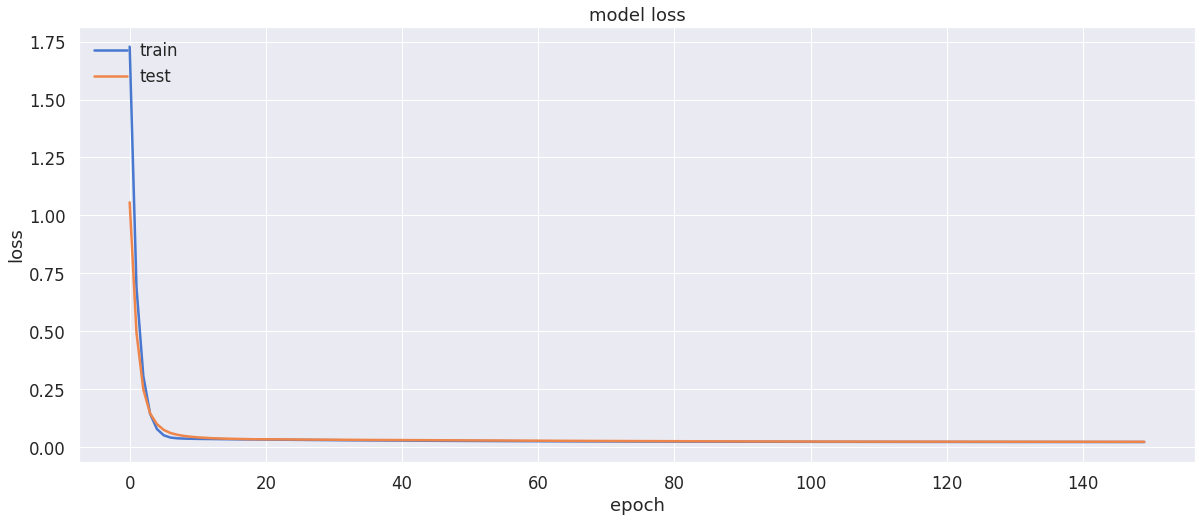

In [19]:
import cf_models as cm

n_users, n_items = X.shape

# fold_number = 0
test_size = 0.1

policy_threshold = 'fmax'
# conf_measure = 'brier' 
n_factors = 100
# alpha = 100

lr = 0.001 
batch_size = 64
epochs = 150    # NOTE that this is typically is not equal to the epochs required for the polarity model

loss_fn = tf.keras.losses.MeanSquaredError()  # Options: cm.confidence_weighted_loss, cm.c_squared_loss, tf.keras.losses.BinaryCrossentropy(), tf.keras.losses.MeanSquaredError(), ...
cf_model = cm.get_cfnet_compiled(n_users, n_items, n_factors, loss=loss_fn, lr=lr)
# cf_model = cm.get_cfnet_approximating_labels(n_users, n_items, n_factors)

# Configure `target_type` (Options: 'generic', 'rating', 'label')
# 1. Choose 'label' if the BCE loss is used (because the CF model in this case attempts to approximates the label encoded in 0 and 1)
# 2. Choose 'rating' if MSE is used (because the CF model in this case approximates the rating, which is a regression problem)
# 3. Choose 'generic' for customized loss function with potentially more complex labeling information where "y_true" is a matrix 
# 
# Note that you are unlikely need to configure `target_type` because cf_models module has a method that will determine this for you automatically
# target_type = 'label'

cf_model = cm.training_with_predicted_filter(
                                 input_model=(cf_model, loss_fn),  # [todo] incorperate polarity model
                                 input_data={'X': X, # X = np.hstack([R, T]),
                                             'P': Pf_seq2seq, 
                                             'C': Cn,  # Use the filtered confidence matrix Cn
                                             'U': U, 
                                             'L_train': L_train}, 

                                # SGD optimization parameters
                                test_size = test_size,
                                epochs = epochs, 
                                batch_size=batch_size, 

                                # CF hyperparameters
                                # n_factors=n_factors, # this is factored into model definition
                                policy_threshold=policy_threshold,
                                # target_type=target_type,
        
                                fold_number=fold_number) 

In [20]:
analyzer = cm.analyze_reconstruction(cf_model, 
                                     X=(R, T),
                                     L=(L_train, lh_seq2seq), # Note that estimated labels on T (lh_seq2seq) is only optional; won't be used 
                                     Pc=Pf_seq2seq, p_threshold=p_threshold, policy_threshold=policy_threshold)
highlight("Reestimate the entire rating matrix (X) with learned latent factors/embeddings")
reestimated = analyzer(L_test, unreliable_only=False)
highlight("Reestimate ONLY the unreliable entries in X with learned latent factors/embeddings")
reestimated = analyzer(L_test, unreliable_only=True, verbose=2)

Reestimate the entire rating matrix (X) with learned latent factors/embeddings
[info] From R to Rh, delta(Frobenius norm)= 32.38305238206948
[info] From T to Th, delta(Frobenius norm)= 13.85749217881791
[info] How different are lh and lh_new? 0.82
[result] Majority vote: F1 score with the original T:  0.19637462235649547
[result] Majority vote: F1 score with re-estimated Th using original p_threshold: 0.19364161849710984
[result] Majority vote: F1 score with re-estimated Th: 0.2140468227424749

[result] Stacking: F1 score with the original T:  0.09859154929577464
[result] Stacking: F1 score with re-estimated Th: 0.1807909604519774

[result] Best settings (complete): lh2_maxvote_pth_adjusted, score: 0.2140468227424749

Reestimate ONLY the unreliable entries in X with learned latent factors/embeddings
[info] From R to Rh, delta(Frobenius norm)= 31.27135275562353
[info] From T to Th, delta(Frobenius norm)= 1.7863760513384033
[info] How different are lh and lh_new? 0.9072
[result] Majority